# ULTIMO tutorial 7: Distribution

In this tutorial, the supply model created in tutorial 1 to 6 is applied for a simple demand model with trip generation and trip distribution.  

In order to distribute traffic, the network model, cost matrices and attraction factors (supply model) that were created in the previous tutorials are imported. The supply model consists of:

- __TAZ__ with attraction factors and subordinate network length
- __Road network__ with edges and nodes per country, as created in tutorial 1
- __Country attributes__ regarding international travel as created in tutorial 6
- _Travel volumes_ as target values per country are read from an external input file

In `release version 1.0`, ULTIMO creates OD matrices for long distance and international travel. For a network assignment, the created network and connectors can be imported to different software.

## Import packages

In [1]:
# for distribution
import distribution.DistributeTraffic as DistributeTraffic

In [2]:
# for reading and saving files etc.
import geopandas as gpd
import pandas as pd
import numpy as np
# for time tracking
from datetime import datetime

## Read input: TAZ and country attributes, cost matrices

The input includes georeferenced TAZ in `EPSG:4326` with the following _required_ attributes (columns):

* __ID__ | field including a unique ID, e.g. the NUTS ID
* __Country__ | field containing the ISO-2 code of the respective country
* __population__ | field containing the population, see `tutorial5`
* __Attraction indices national and international__ | fields containing the attraction index for national and international distribution, see `tutorial5`
* __Matrix index__ | field containing the index of the TAZ in the cost matrix, see `tutorial4`
* __Subordinate network length__ | field containing the aggregated length of the subordinate roads per TAZ, see `tutorial1`
 
Using ULTIMO, many of these fields were created following the previous tutorials (1-6). For distribution, the relevant TAZ files will be merged to one `GeoDataFrame` with all the needed information.

The country attributes are contained in the file created in `tutorial6`. The last thing missing are the target values, which will be imported as an external input and merged to the country `GeoDataFrame`.

The cost of travel in the form of travel times and distances between the TAZ is a key component of the distribution, thus the cost matrices created in `tutorial4` are also needed as an input.

In [3]:
# load base TAZ file
taz = gpd.GeoDataFrame.from_file('tutorial-files/_input/taz-tutorial.gpkg')

# defining ID, country and geometry column names of taz
taz_id = "nuts_id"
taz_cn = "cntr_code"
taz_geo = "geometry"

taz.head()

,nuts_id,cntr_code,nuts_name,geometry
0,FI193,FI,Keski-Suomi,"MULTIPOLYGON (((26.13865 63.45759, 26.16055 63..."
1,FI194,FI,Etelä-Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.63880 62..."
2,FI195,FI,Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.52578 62..."
3,FI196,FI,Satakunta,"MULTIPOLYGON (((21.41993 61.04744, 21.42015 61..."
4,FI197,FI,Pirkanmaa,"MULTIPOLYGON (((22.83124 62.27089, 22.90118 62..."


Combine tutorial results to single TAZ GeoDataFrame:

In [4]:
# load all tutorial TAZ results and merge to taz
# attraction factors
taz_t5 = gpd.GeoDataFrame.from_file('tutorial-files/tutorial5/taz-tutorial-attindex.gpkg')[[taz_id, 'population', 'index_nat', 'index_int']]
# matrix index (id)
taz_t4 = gpd.GeoDataFrame.from_file('tutorial-files/tutorial4/taz-tutorial-id.gpkg')[[taz_id, 'id']]
# subordinate network length
taz_t1 = gpd.GeoDataFrame.from_file('tutorial-files/tutorial1/taz-tutorial-len.gpkg')[[taz_id, 'length_sub']]

# merge
taz = taz.merge(taz_t5, on=taz_id, how='left')
taz = taz.merge(taz_t4, on=taz_id, how='left')
taz = taz.merge(taz_t1, on=taz_id, how='left')

del taz_t5, taz_t4, taz_t1

taz.head()

,nuts_id,cntr_code,nuts_name,geometry,population,index_nat,index_int,id,length_sub
0,FI193,FI,Keski-Suomi,"MULTIPOLYGON (((26.13865 63.45759, 26.16055 63...",510850.572340,0.903992,0.889445,11,1130.241897
1,FI194,FI,Etelä-Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.63880 62...",358466.021589,0.818465,0.805294,12,871.008000
2,FI195,FI,Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.52578 62...",340041.957401,0.698118,0.686884,13,607.585794
3,FI196,FI,Satakunta,"MULTIPOLYGON (((21.41993 61.04744, 21.42015 61...",358255.966908,0.919390,0.904596,14,498.395849
4,FI197,FI,Pirkanmaa,"MULTIPOLYGON (((22.83124 62.27089, 22.90118 62...",901022.640876,1.607394,1.581528,15,974.549378


In [5]:
countries = taz[taz_cn].unique()

Read country attributes created in `tutorial6`

In [6]:
country_layer = gpd.GeoDataFrame.from_file('tutorial-files/tutorial6/country-attributes.gpkg')
country_layer

,cntr_code,index,border_share,border_length,border_length_shared,border_crossings_count,neighbors,population,area,geometry
0,DK,0,0.015467,4088.436575,63.236291,5.0,2,8.396369e+06,43653.093630,"MULTIPOLYGON (((10.26796 55.03071, 10.27580 55..."
1,FI,0,0.269796,8715.390137,2351.374349,136.0,3,9.547163e+06,337512.028767,"MULTIPOLYGON (((19.96477 59.98505, 19.96479 59..."
2,NO,0,0.101108,24434.055949,2470.468692,176.0,3,8.527085e+06,322504.893423,"MULTIPOLYGON (((4.88766 59.29444, 4.88027 59.2..."
3,SE,0,0.213012,9981.249404,2126.124196,128.0,3,1.621385e+07,449736.409751,"MULTIPOLYGON (((12.71874 55.89266, 12.69803 55..."


Add target values for total personal km (car pkm) and tonne kilometers (freight tkm):

In [7]:
country_layer = country_layer.merge(pd.read_csv('tutorial-files/_input/targets-tutorial.csv')[[taz_cn, 'car_mio_pkm', 'freight_mio_tkm']], on=taz_cn)
country_layer

,cntr_code,index,border_share,border_length,border_length_shared,border_crossings_count,neighbors,population,area,geometry,car_mio_pkm,freight_mio_tkm
0,DK,0,0.015467,4088.436575,63.236291,5.0,2,8.396369e+06,43653.093630,"MULTIPOLYGON (((10.26796 55.03071, 10.27580 55...",60000,15000
1,FI,0,0.269796,8715.390137,2351.374349,136.0,3,9.547163e+06,337512.028767,"MULTIPOLYGON (((19.96477 59.98505, 19.96479 59...",65000,17000
2,NO,0,0.101108,24434.055949,2470.468692,176.0,3,8.527085e+06,322504.893423,"MULTIPOLYGON (((4.88766 59.29444, 4.88027 59.2...",65000,20000
3,SE,0,0.213012,9981.249404,2126.124196,128.0,3,1.621385e+07,449736.409751,"MULTIPOLYGON (((12.71874 55.89266, 12.69803 55...",100000,50000


Cost matrices

In [8]:
cost_mtx = np.load('tutorial-files/tutorial4/cost-matrices.npy')
cost_mtx.shape # (origin, destination, cost), cost: 0=travel time, 1=distance

(69, 69, 2)

## National distribution

In an iteration over the countries, national long and short distance transport is distributed. This results in
- OD-matrices for long-distance transport
- network loads as columns in the edges `GeoDataFrame` for short-distance transport

The distribution is performed for both private and freight road-based transport.

First, the target values per sector (national and international, long- and short-distance) are determined based on the country attributes from `tutorial6` and the overall target in travel volume. The target values include VKT and trips. Then, these sector targets are applied as input for the
- __long-distance gravity model__
- __short-distance weighted network assignment__

For short distance travel, a part of the VKT is assigned to the subordinate road network, which is not inlcuded in the road network model as edges. For this, the aggregated network length per TAZ is used, and the resulting subordniate network VKT are added as an attribute of the TAZ. 

In [9]:
path_export = 'tutorial-files/tutorial7/'
path_import = 'tutorial-files/tutorial1/'

In [10]:
gm = DistributeTraffic.GravityModel(cost_mtx, taz, taz_cn='cntr_code')

Distribution

In [11]:
print('Starting national distribution: {}'.format(datetime.now()))
taz_with_subvkt = pd.DataFrame()

for cn in countries[:]:
    print(cn)
    # get targets
    tv = DistributeTraffic.TargetValues(country_layer)
    pt=tv.targets_personal_transport(cn=cn, target_col='car_mio_pkm')
    ft=tv.targets_freight_transport(cn=cn, target_col='freight_mio_tkm')
    
    # get OD matrices
    trips_pt = gm.trip_distribution_pt(target=pt['long'], cn=cn, mob_rate=25)  # cars (personal transport)
    trips_ft = gm.trip_distribution_ft(target_vkt=ft['long'], target_trips=ft['trips_long'], cn=cn)  # trucks (freight transport)
    
    # save country OD matrices
    trips_cn = np.zeros((trips_pt.shape[0], trips_pt.shape[0], 2))
    trips_cn[:,:,0] += trips_pt
    trips_cn[:,:,1] += trips_ft
    np.save('tutorial-files/tutorial7/{}-nat.npy'.format(cn), trips_cn)
    
    # intrazonal network loads
    net = gpd.GeoDataFrame.from_file(path_import + '{}_e'.format(cn) + '.gpkg')
    # private transport - VKT per TAZ is determined and distributed to all edges within each TAZ 
    iz = DistributeTraffic.IntraZonal(taz[taz['cntr_code']==cn], net)
    targets = {'car': pt['short']}
    net_r, taz_pt = iz.road_type_weighted_single(target=targets, veh_types=['car'])
    del net
    # ft - VKT per TAZ is determined and distributed to all edges within each TAZ and surrounding TAZ within a 50km range
    taz_pt.to_crs(epsg=3035, inplace=True)
    taz_pt['area'] = taz_pt.area  # area per TAZ (smaller TAZ always get surrounding TAZ included, independent from distance)
    iz = DistributeTraffic.IntraZonal(taz_pt, net_r)
    net_r, taz_ft = iz.road_type_weighted_multiple(target=ft['short_segments_vkm'], matrix_dis=cost_mtx[:,:,1], index='index_nat', fac_cell=1.5, distance=50000)
    
    # merge taz_pt and taz_ft
    taz_r= taz_pt.merge(taz_ft, on=taz_id)
    
    # save net with intrazonal traffic to file
    net_r.to_file(path_export + '{}_short'.format(cn) + '.gpkg', driver='GPKG')
    # add taz_r to result taz
    taz_with_subvkt = pd.concat([taz_with_subvkt, taz_r])

taz_with_subvkt = taz_with_subvkt.set_geometry(taz_geo)
taz_with_subvkt.crs = 3035
taz_with_subvkt.to_crs(epsg=4326, inplace=True)

taz_with_subvkt.to_file(path_export + 'taz-tutorial-vkt' + '.gpkg', driver='GPKG')
    
print('Finished at {}'.format(datetime.now()))
taz_with_subvkt.head()

Starting national distribution: 2023-03-20 12:31:25.320446
FI
Scaling factor personal transport for FI: 0.4490421116342207
Freight transport gravity model result for FI: Relation to target vkm 0.9910435259393833
DK
Scaling factor personal transport for DK: 0.940780924347826
Freight transport gravity model result for DK: Relation to target vkm 0.7624308514138889
SE
Scaling factor personal transport for SE: 0.38607105515386103
Freight transport gravity model result for SE: Relation to target vkm 0.97013065643473


V:\Projekte\ELK\ultimo-python\distribution\DistributeTraffic.py:651: RuntimeWarning: divide by zero encountered in double_scalars
  taz_veh = taz_vkt / agg_w_len


NO
Scaling factor personal transport for NO: 0.3621314714443569
Freight transport gravity model result for NO: Relation to target vkm 0.7789780510136224
Finished at 2023-03-20 12:32:15.994191


,nuts_id,cntr_code,nuts_name,geometry,population,index_nat,index_int,id,length_sub,car_sub,area,lcv_sub,mft_sub,hft_sub
0,FI193,FI,Keski-Suomi,"MULTIPOLYGON (((26.13865 63.45759, 26.16055 63...",510850.572340,0.903992,0.889445,11,1130.241897,2.369736e+08,1.995183e+10,0.0,0.0,0.0
1,FI194,FI,Etelä-Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.63880 62...",358466.021589,0.818465,0.805294,12,871.008000,1.573763e+08,1.399198e+10,0.0,0.0,0.0
2,FI195,FI,Pohjanmaa,"MULTIPOLYGON (((21.64783 62.01959, 21.52578 62...",340041.957401,0.698118,0.686884,13,607.585794,2.032313e+08,7.830521e+09,0.0,0.0,0.0
3,FI196,FI,Satakunta,"MULTIPOLYGON (((21.41993 61.04744, 21.42015 61...",358255.966908,0.919390,0.904596,14,498.395849,1.457683e+08,8.239117e+09,0.0,0.0,0.0
4,FI197,FI,Pirkanmaa,"MULTIPOLYGON (((22.83124 62.27089, 22.90118 62...",901022.640876,1.607394,1.581528,15,974.549378,4.366002e+08,1.461289e+10,0.0,0.0,0.0


<AxesSubplot:>

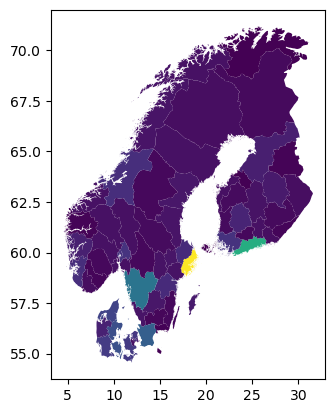

In [12]:
taz_with_subvkt.plot(column='car_sub', kind='geo')

## International distribution

The international distribution results in
- OD-matrices for international transport

The distribution is performed for both private and freight road-based transport.

First, the target values per sector (national and international, long- and short-distance) are determined based on the country attributes from `tutorial6` and the overall target in travel volume. The target values include VKT/PKT and trips. Then, these sector targets are applied as input for the
- __long-distance gravity model__

In contrast to the national distribution, all TAZ are included in the distribution. The international target values per country are calculated and applied for trip generation. 

In this tutorial, other surroundung countries are not included, which influences the result. For a project application, we would recommend to include the direct neighbors to the region into the model in order to get a realistic depiction of border-crossing travel.

First, the travel volume targets for international trips per country are determined and saved to a dictionary:

In [16]:
targets_int_pt = {}
targets_int_ft = {}
for cn in countries[:]:
    print(cn)
    # get targets
    tv = DistributeTraffic.TargetValues(country_layer)
    pt=tv.targets_personal_transport(cn=cn, target_col='car_mio_pkm')
    ft=tv.targets_freight_transport(cn=cn, target_col='freight_mio_tkm')

    # save international targets
    targets_int_pt.update({cn: {'int': pt['int'], 'trans': pt['trans']}})
    targets_int_ft.update({cn: {'int_vkt': ft['int'], 'int_trips': ft['trips_int'], 'trans_vkt': ft['transit']}})

# aggregate personal transport vkt (only int, trans is control value)
target_pt = sum([targets_int_pt[cn]['int'] for cn in targets_int_pt])
# aggregate freight transport vkt (only int, trans is control value)
target_ft_vkt = sum([targets_int_ft[cn]['int_vkt'] for cn in targets_int_ft])

target_pt, target_ft_vkt

FI
DK
SE
NO


(3253124003.379552, 3149043163.39295)

These targets are used to create an international OD-Matrix

In [17]:
# OD matrix personal transport
print(datetime.now())
trips_pt_int = gm.trip_distribution_pt(target_pt, mob_rate=0.25)
print(datetime.now())

2023-03-20 12:36:38.852683
Scaling factor personal transport for None: 0.3996563454235578
2023-03-20 12:36:40.218844


In [18]:
# OD matrix freight transport
print(datetime.now())
trips_ft_int = gm.trip_distribution_ft(target_vkt=target_ft_vkt, target_trips=targets_int_ft, trips_key='int_trips')
print(datetime.now())

2023-03-20 12:36:42.037312
Freight transport gravity model result for None: Relation to target vkm 0.4075921353527611
2023-03-20 12:36:43.342348


In [19]:
# save international OD matrices
trips_int = np.zeros((trips_pt_int.shape[0], trips_pt_int.shape[0], 2))
trips_int[:,:,0] += trips_pt_int
trips_int[:,:,1] += trips_ft_int
np.save('tutorial-files/tutorial7/int.npy', trips_int)